In [1]:
import sys
# import sklearn
import numpy as np
import pandas as pd
from time import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from copy import deepcopy
pd.set_option('display.max_columns', 50)
f"Python: {sys.version}"

'Python: 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]'

### Setup

In [2]:
trainData = pd.read_csv("tcdml1920-rec-click-pred--training.csv", index_col='recommendation_set_id', low_memory=False)
testData = pd.read_csv("tcdml1920-rec-click-pred--test.csv", index_col='recommendation_set_id', low_memory=False)

#drops 1647 rows with nothing
testData.dropna(how="all", inplace=True)

In [3]:
# Row Duplication check TrainData
duplicateRowsTrain = trainData[trainData.duplicated()]
duplicateRowsTrain.shape

(285, 45)

In [4]:
# Row Duplication check TestData
duplicateRowsTest = testData[testData.duplicated()]
duplicateRowsTest.shape

(0, 45)

In [5]:
trainData = trainData.drop_duplicates()
trainData.shape

(385402, 45)

In [6]:
trainData.replace(["\\N", "nA", "Not provided", "unknown", "*unknown*"], np.nan, inplace=True)
testData.replace(["\\N", "nA", "Not provided",  "unknown", "*unknown*"], np.nan, inplace=True)

In [7]:
numeric_columns = [
    "query_word_count",
    "query_char_count",
    "query_document_id",
    "year_published",
    "number_of_authors",
    "abstract_char_count",
    "abstract_word_count",
    "first_author_id",
    "num_pubs_by_first_author",
    "hour_request_received",
    "local_hour_of_request",
    "recommendation_algorithm_id_used",
    "clicks",
]

In [8]:
time_columns = [
    "request_received",
    "response_delivered",
    "local_time_of_request",
    "time_recs_recieved",
    "time_recs_displayed",
    "time_recs_viewed",
]

In [9]:
for col in numeric_columns:
    trainData[col] = pd.to_numeric(trainData[col], errors="coerce")
    testData[col] = pd.to_numeric(testData[col], errors="coerce")

In [10]:
for col in time_columns:
    trainData[col] = pd.to_datetime(trainData[col], format="%d/%m/%Y %H:%M")
    testData[col] = pd.to_datetime(testData[col], format="%d/%m/%Y %H:%M")

In [11]:
JabRef_trainData = deepcopy(trainData[trainData.organization_id == 1])
JabRef_testData  = deepcopy(testData[testData.organization_id == 1])
MyVolts_trainData = deepcopy(trainData[trainData.organization_id == 4])
MyVolts_testData  = deepcopy(testData[testData.organization_id == 4])
Blog_trainData = deepcopy(trainData[trainData.organization_id == 8])
Blog_testData  = deepcopy(testData[testData.organization_id == 8])

In [12]:
JabRef_trainData.shape

(270037, 45)

In [13]:
JabRef_dropCols = [0,1,2,4,7,11,15,16,17,18,20,29,30,32,39,40,41,42,43]
JabRef_trainData1 = JabRef_trainData.drop(JabRef_trainData.columns[JabRef_dropCols],axis=1)
JabRef_testData1 = JabRef_testData.drop(JabRef_testData.columns[JabRef_dropCols],axis=1)
JabRef_trainData1.shape

(270037, 27)

In [14]:
MyVolts_dropCols = [4,6,7,9,11,13,14,15,16,18,20,22,23,24,25,26,27,29,30,32,39,40,41,42,43]
MyVolts_trainData1 = MyVolts_trainData.drop(MyVolts_trainData.columns[MyVolts_dropCols],axis=1)
MyVolts_testData1 = MyVolts_testData.drop(MyVolts_testData.columns[MyVolts_dropCols],axis=1)
MyVolts_trainData1.shape

(100144, 21)

In [15]:
Blog_dropCols = [0,1,4,6,7,9,11,13,14,15,16,17,18,20,22,23,24,25,26,27,29,30,32,39,40,41,42,43]
Blog_trainData1 = Blog_trainData.drop(Blog_trainData.columns[MyVolts_dropCols],axis=1)
Blog_testData1 = Blog_testData.drop(Blog_testData.columns[MyVolts_dropCols],axis=1)
Blog_trainData1.shape

(15221, 21)

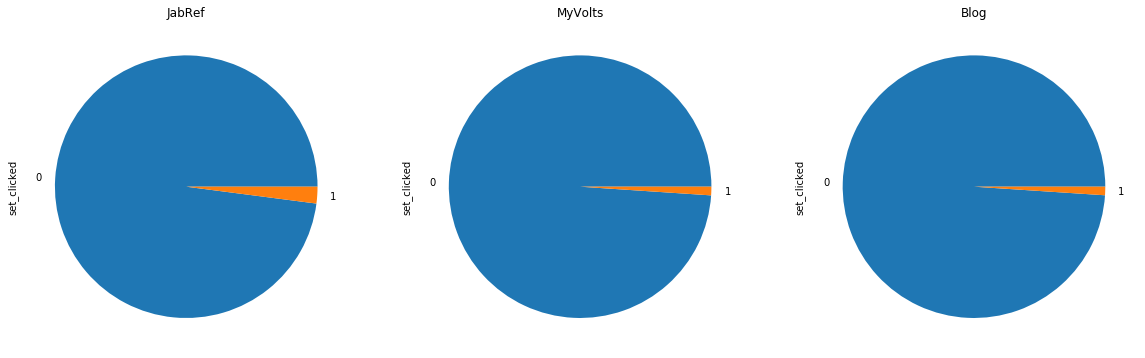

In [16]:
plt.figure(figsize=(20,8))
plt.subplot(1, 3, 1)
JabRef_trainData['set_clicked'].value_counts().plot(kind='pie')
plt.title('JabRef')
plt.subplot(1, 3, 2)
MyVolts_trainData['set_clicked'].value_counts().plot(kind='pie')
plt.title('MyVolts')
plt.subplot(1, 3, 3)
Blog_trainData['set_clicked'].value_counts().plot(kind='pie')
plt.title('Blog')
plt.show()

In [25]:
JabRef_trainData1[JabRef_trainData1['set_clicked']==1].isnull().sum().sort_values()

query_word_count                       0
search_keywords                        0
search_title                           0
search_abstract                        0
rec_processing_time                    0
response_delivered                     0
hour_request_received                  0
set_clicked                            0
app_version                            9
query_detected_language               30
app_lang                              38
country_by_ip                         42
algorithm_class                      278
recommendation_algorithm_id_used     278
local_hour_of_request                598
cbf_parser                          1370
query_document_id                   3728
year_published                      3849
number_of_authors                   3860
num_pubs_by_first_author            3955
first_author_id                     3955
abstract_word_count                 4087
abstract_detected_language          4088
user_os                             5506
user_timezone   

In [24]:
JabRef_testData1.isnull().sum().sort_values()

query_word_count                       0
search_keywords                        0
search_title                           0
search_abstract                        0
hour_request_received                  0
app_version                            4
app_lang                              19
country_by_ip                         31
query_detected_language               51
recommendation_algorithm_id_used     229
algorithm_class                      231
local_hour_of_request                509
cbf_parser                          1379
query_document_id                   3645
year_published                      3737
number_of_authors                   3766
first_author_id                     3807
num_pubs_by_first_author            3807
abstract_word_count                 3994
abstract_detected_language          3997
user_os                             5161
user_timezone                       5161
user_java_version                   5176
rec_processing_time                 5176
response_deliver

In [28]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
str_cols = df.select_dtypes(include=['object']).columns

df.loc[:, num_cols] = df.loc[:, num_cols].fillna(0)
df.loc[:, str_cols] = df.loc[:, str_cols].fillna('')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100144 entries, 243679 to 459535
Data columns (total 21 columns):
user_id                             51818 non-null object
session_id                          51818 non-null object
query_identifier                    100004 non-null object
query_word_count                    100004 non-null float64
query_detected_language             100004 non-null object
year_published                      0 non-null float64
abstract_word_count                 75135 non-null float64
abstract_detected_language          75135 non-null object
item_type                           64321 non-null object
hour_request_received               100144 non-null int64
response_delivered                  100144 non-null datetime64[ns]
rec_processing_time                 100144 non-null float64
country_by_ip                       100018 non-null object
local_hour_of_request               40447 non-null float64
recommendation_algorithm_id_used    100144 non-null float

In [18]:
JabRef_trainData1['set_clicked'].value_counts()

0    264491
1      5546
Name: set_clicked, dtype: int64

In [19]:
threshold = 0.22

# #Dropping rows with missing value rate higher than threshold
# trainData.loc[trainData.isnull().mean(axis=1) < threshold].shape

a = JabRef_trainData1[(JabRef_trainData1['set_clicked']==0)]
a.loc[a.isnull().mean(axis=1) < threshold].shape
# .isnull().sum().sort_values()

(47224, 27)

In [20]:
a.sample(5546)

,query_word_count,query_detected_language,query_document_id,year_published,number_of_authors,abstract_word_count,abstract_detected_language,first_author_id,num_pubs_by_first_author,hour_request_received,response_delivered,rec_processing_time,app_version,app_lang,user_os,user_os_version,user_java_version,user_timezone,country_by_ip,local_hour_of_request,recommendation_algorithm_id_used,algorithm_class,cbf_parser,search_title,search_keywords,search_abstract,set_clicked
recommendation_set_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
193585,6.0,it,81471648.0,2017.0,2.0,250.0,en,6913614.0,22.0,10,2019-04-25 10:40:00,0.103812,4.3.1,en,NaN,NaN,NaN,NaN,DE,10.0,22.0,same_author,NaN,no,no,no,0
158843,2.0,en,21197129.0,1999.0,NaN,19.0,en,NaN,NaN,14,2019-03-23 14:19:00,4.483670,4.3.1,en,NaN,NaN,NaN,NaN,DE,NaN,15.0,content_based_filtering,mlt_QP,yes,no,yes,0
223762,6.0,en,20568796.0,1961.0,1.0,20.0,en,2542795.0,42.0,17,2019-05-27 17:37:00,5.738740,4.3.1,en,NaN,NaN,NaN,NaN,DE,17.0,1.0,content_based_filtering,standard_QP,yes,no,no,0
69603,12.0,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,2018-12-30 22:17:00,5.892410,4.3.1,en,NaN,NaN,NaN,NaN,DE,22.0,13.0,content_based_filtering,standard_QP,yes,no,yes,0
154908,7.0,en,12179177.0,2000.0,1.0,144.0,en,2736505.0,331.0,13,2019-03-20 13:51:00,5.466960,4.3.1,en,NaN,NaN,NaN,NaN,DE,13.0,21.0,sentence_embeddings,NaN,no,no,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322947,13.0,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,2019-07-13 22:04:00,6.384690,4,de,NaN,NaN,NaN,NaN,DE,22.0,11.0,content_based_filtering,edismax_QP,yes,no,no,0
260032,7.0,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,2019-06-27 14:45:00,3.053320,4.3.1,en,NaN,NaN,NaN,NaN,GB,13.0,12.0,content_based_filtering,edismax_QP,yes,yes,yes,0
188502,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,2019-04-19 11:36:00,0.073033,4.3.1,ru,NaN,NaN,NaN,NaN,RU,NaN,14.0,content_based_filtering,edismax_QP,yes,no,yes,0
